<a href="https://colab.research.google.com/github/yd-14/HRNet-fundus-image-segmentation/blob/main/HRNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Data loading

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np

def clahe_image(img):
    img = img.astype('uint8')
    img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    lab_image = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)
    
    l, a, b = cv2.split(lab_image)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    clahe_lab_image = cv2.merge((cl, a, b))

    final_image = cv2.cvtColor(clahe_lab_image, cv2.COLOR_LAB2RGB)

    final_image = final_image.astype('float32')
    return final_image

def histo_equal(img):
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    equalized_image = cv2.equalizeHist(img)

    final_image = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    final_image = final_image.astype('float32')
    return final_image

def preprocess_image(img):
    return histo_equal(clahe_image(img))

def custom_generator(images_path, masks_path, batch_size, image_size):
    image_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_image)
    mask_datagen = ImageDataGenerator(rescale=1./255)

    image_generator = image_datagen.flow_from_directory(
        directory=images_path,
        target_size=image_size,
        class_mode=None,
        batch_size=batch_size,
        seed=1,
    )

    mask_generator = mask_datagen.flow_from_directory(
        directory=masks_path,
        target_size=image_size,
        class_mode=None,
        color_mode='grayscale',
        batch_size=batch_size,
        seed=1
    )

    while True:
        X_batch = image_generator.next()
        y_batch = mask_generator.next()
        yield X_batch, y_batch

In [ ]:
images_path='/content/gdrive/MyDrive/MiniProjectDataset/Refuge/train/images'
image_size=(256,256)
batch_size= 8
mask_path='/content/gdrive/MyDrive/MiniProjectDataset/Refuge/train/OD_gts'

my_generator= custom_generator(images_path, mask_path, batch_size, image_size)
#imgs, msks = next(my_generator)

## Image Data Generator Test

In [ ]:
import matplotlib.pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
(8, 256, 256, 3)


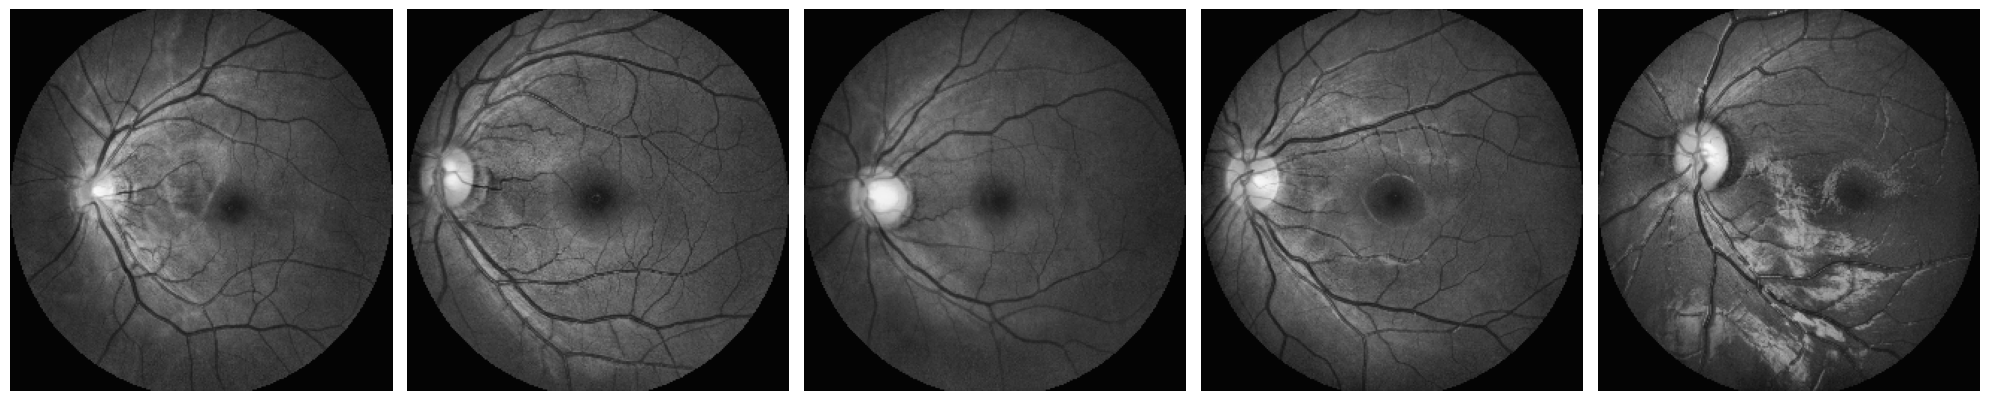

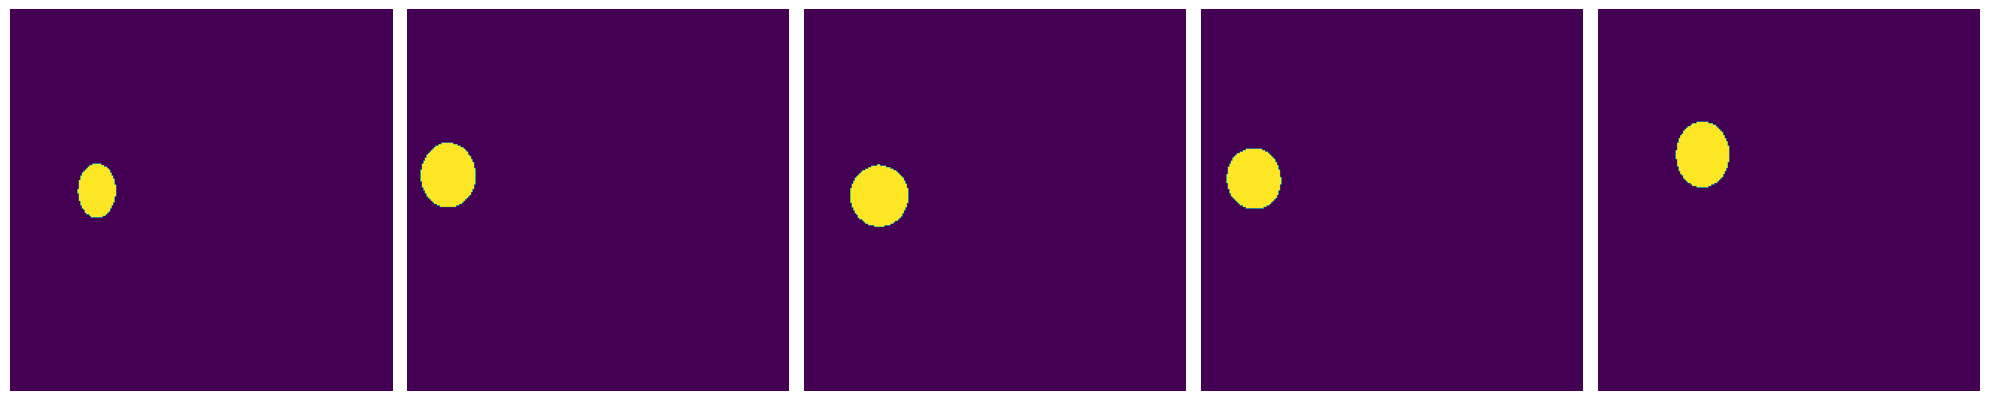

In [ ]:
imgs, msks=next(my_generator)
print(imgs.shape)
# from google.colab.patches import cv2_imshow
# for i in img:
#     cv2_imshow(i)
plotImages(imgs)
plotImages(msks)

#Model 

In [ ]:
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Lambda
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

## Utility Functions

In [ ]:
from keras.layers import UpSampling2D, Conv2D

def conv2d_block(input_tensor, n_filters):
  '''  
    creates a block of 4 convolution layers stacked together used in each stream of different resolution
    args:
      input_tensor
      n_filter: number of filters (C)
  '''
  x= Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', activation='relu')(input_tensor)
  x= Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
  x= Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
  x= Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
  return x

def upsample(input_tensor, n_filters):
  '''
    upsample from (H x W x 2C) to (2H x 2W x n_filter)
        (n_filter should be C in HRNet)
  '''
  # Upsample using bilinear interpolation
  upsample = UpSampling2D(size=(2, 2), interpolation='bilinear')(input_tensor)

  # Perform 1x1 convolution
  x = Conv2D(filters=n_filters, kernel_size=(1, 1), activation='relu')(upsample)
  return x

def downsample(input_tensor, n_filters):
  downsampled_tensor = Conv2D(filters=n_filters, kernel_size=(3,3), strides=(2,2), padding='same')(input_tensor)
  return downsampled_tensor

In [ ]:
import numpy as np
def dice_coefficient(binary_segmentation, binary_gt_label):
    '''
    Compute the Dice coefficient between two binary segmentation.
    Dice coefficient is defined as here: https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
    Input:
        binary_segmentation: binary 2D numpy array representing the region of interest as segmented by the algorithm
        binary_gt_label: binary 2D numpy array representing the region of interest as provided in the database
    Output:
        dice_value: Dice coefficient between the segmentation and the ground truth
    '''

    # turn all variables to booleans, just in case
    binary_segmentation = np.asarray(binary_segmentation, dtype=bool)
    binary_gt_label = np.asarray(binary_gt_label, dtype=bool)

    # compute the intersection
    intersection = np.logical_and(binary_segmentation, binary_gt_label)

    # count the number of True pixels in the binary segmentation
    segmentation_pixels = float(np.sum(binary_segmentation.flatten()))
    # same for the ground truth
    gt_label_pixels = float(np.sum(binary_gt_label.flatten()))
    # same for the intersection
    intersection = float(np.sum(intersection.flatten()))

    # compute the Dice coefficient
    dice_value = 2 * intersection / (segmentation_pixels + gt_label_pixels)

    # return it
    return dice_value

def dice_cup(segmentation, gt_label):
    segmentation=segmentation.numpy()
    gt_label=gt_label.numpy()
    # compute the Dice coefficient for the optic cup
    cup_dice = dice_coefficient(segmentation==0, gt_label==0)
    return cup_dice

def dice_disc(segmentation, gt_label):
    segmentation=segmentation.numpy()
    gt_label=gt_label.numpy()
    # compute the Dice coefficient for the optic disc
    disc_dice = dice_coefficient(segmentation<255, gt_label<255)
    return disc_dice

## Model definition and compiling

In [ ]:
from keras.layers import Input, Concatenate
from keras.models import Model

input_shape = (256, 256, 3)
C = 64
dropout = 0.1

inputs = Input(shape=input_shape)

###stage 1
c11 = conv2d_block(inputs, C * 1)

### stage 2
c21 = conv2d_block(c11, C * 1)
c11_d1 = downsample(c11, C * 2)
c22 = conv2d_block(c11_d1, C * 2)

### stage 3
c22_u1 = upsample(c22, C * 1)
concat31 = Concatenate(axis=-1)([c21, c22_u1])
c31 = conv2d_block(concat31, C * 1)

c21_d1 = downsample(c21, C * 2)
concat32 = Concatenate(axis=-1)([c22, c21_d1])
c32 = conv2d_block(concat32, C * 2)

c21_d2 = downsample(c21_d1, C * 4)
c22_d1 = downsample(c22, C * 4)
concat33 = Concatenate(axis=-1)([c21_d2, c22_d1])
c33 = conv2d_block(concat33, C * 4)

### stage 4

c31_d1 = downsample(c31, C * 2)
c31_d2 = downsample(c31_d1, C * 4)
c31_d3 = downsample(c31_d2, C * 8)

c32_d1 = downsample(c32, C * 4)
c32_d2 = downsample(c32_d1, C * 8)

c33_d1 = downsample(c33, C * 8)

c33_u1 = upsample(c33, C * 2)
c33_u2 = upsample(c33_u1, C * 1)

c32_u1 = upsample(c32, C * 1)

concat41 = Concatenate(axis=-1)([c31, c32_u1, c33_u2])
c41 = conv2d_block(concat41, C * 1)

concat42 = Concatenate(axis=-1)([c31_d1, c32, c33_u1])
c42 = conv2d_block(concat42, C * 2)

concat43 = Concatenate(axis=-1)([c31_d2, c32_d1, c33])
c43 = conv2d_block(concat43, C * 4)

concat44 = Concatenate(axis=-1)([c31_d3, c32_d2, c33_d1])
c44 = conv2d_block(concat44, C * 8)

### concatenate output
c42_u1 = upsample(c42, C * 1)

c43_u1 = upsample(c43, C * 2)
c43_u2 = upsample(c43_u1, C * 1)

c44_u1 = upsample(c44, C * 4)
c44_u2 = upsample(c44_u1, C * 2)
c44_u3 = upsample(c44_u2, C * 1)

concat=Concatenate(axis=-1)([c41, c42_u1, c43_u2, c44_u3])
outputs = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), activation='sigmoid')(concat)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics='accuracy')

In [ ]:
# c44.shape

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_61 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_62 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_61[0][0]']              
                                )                                                           

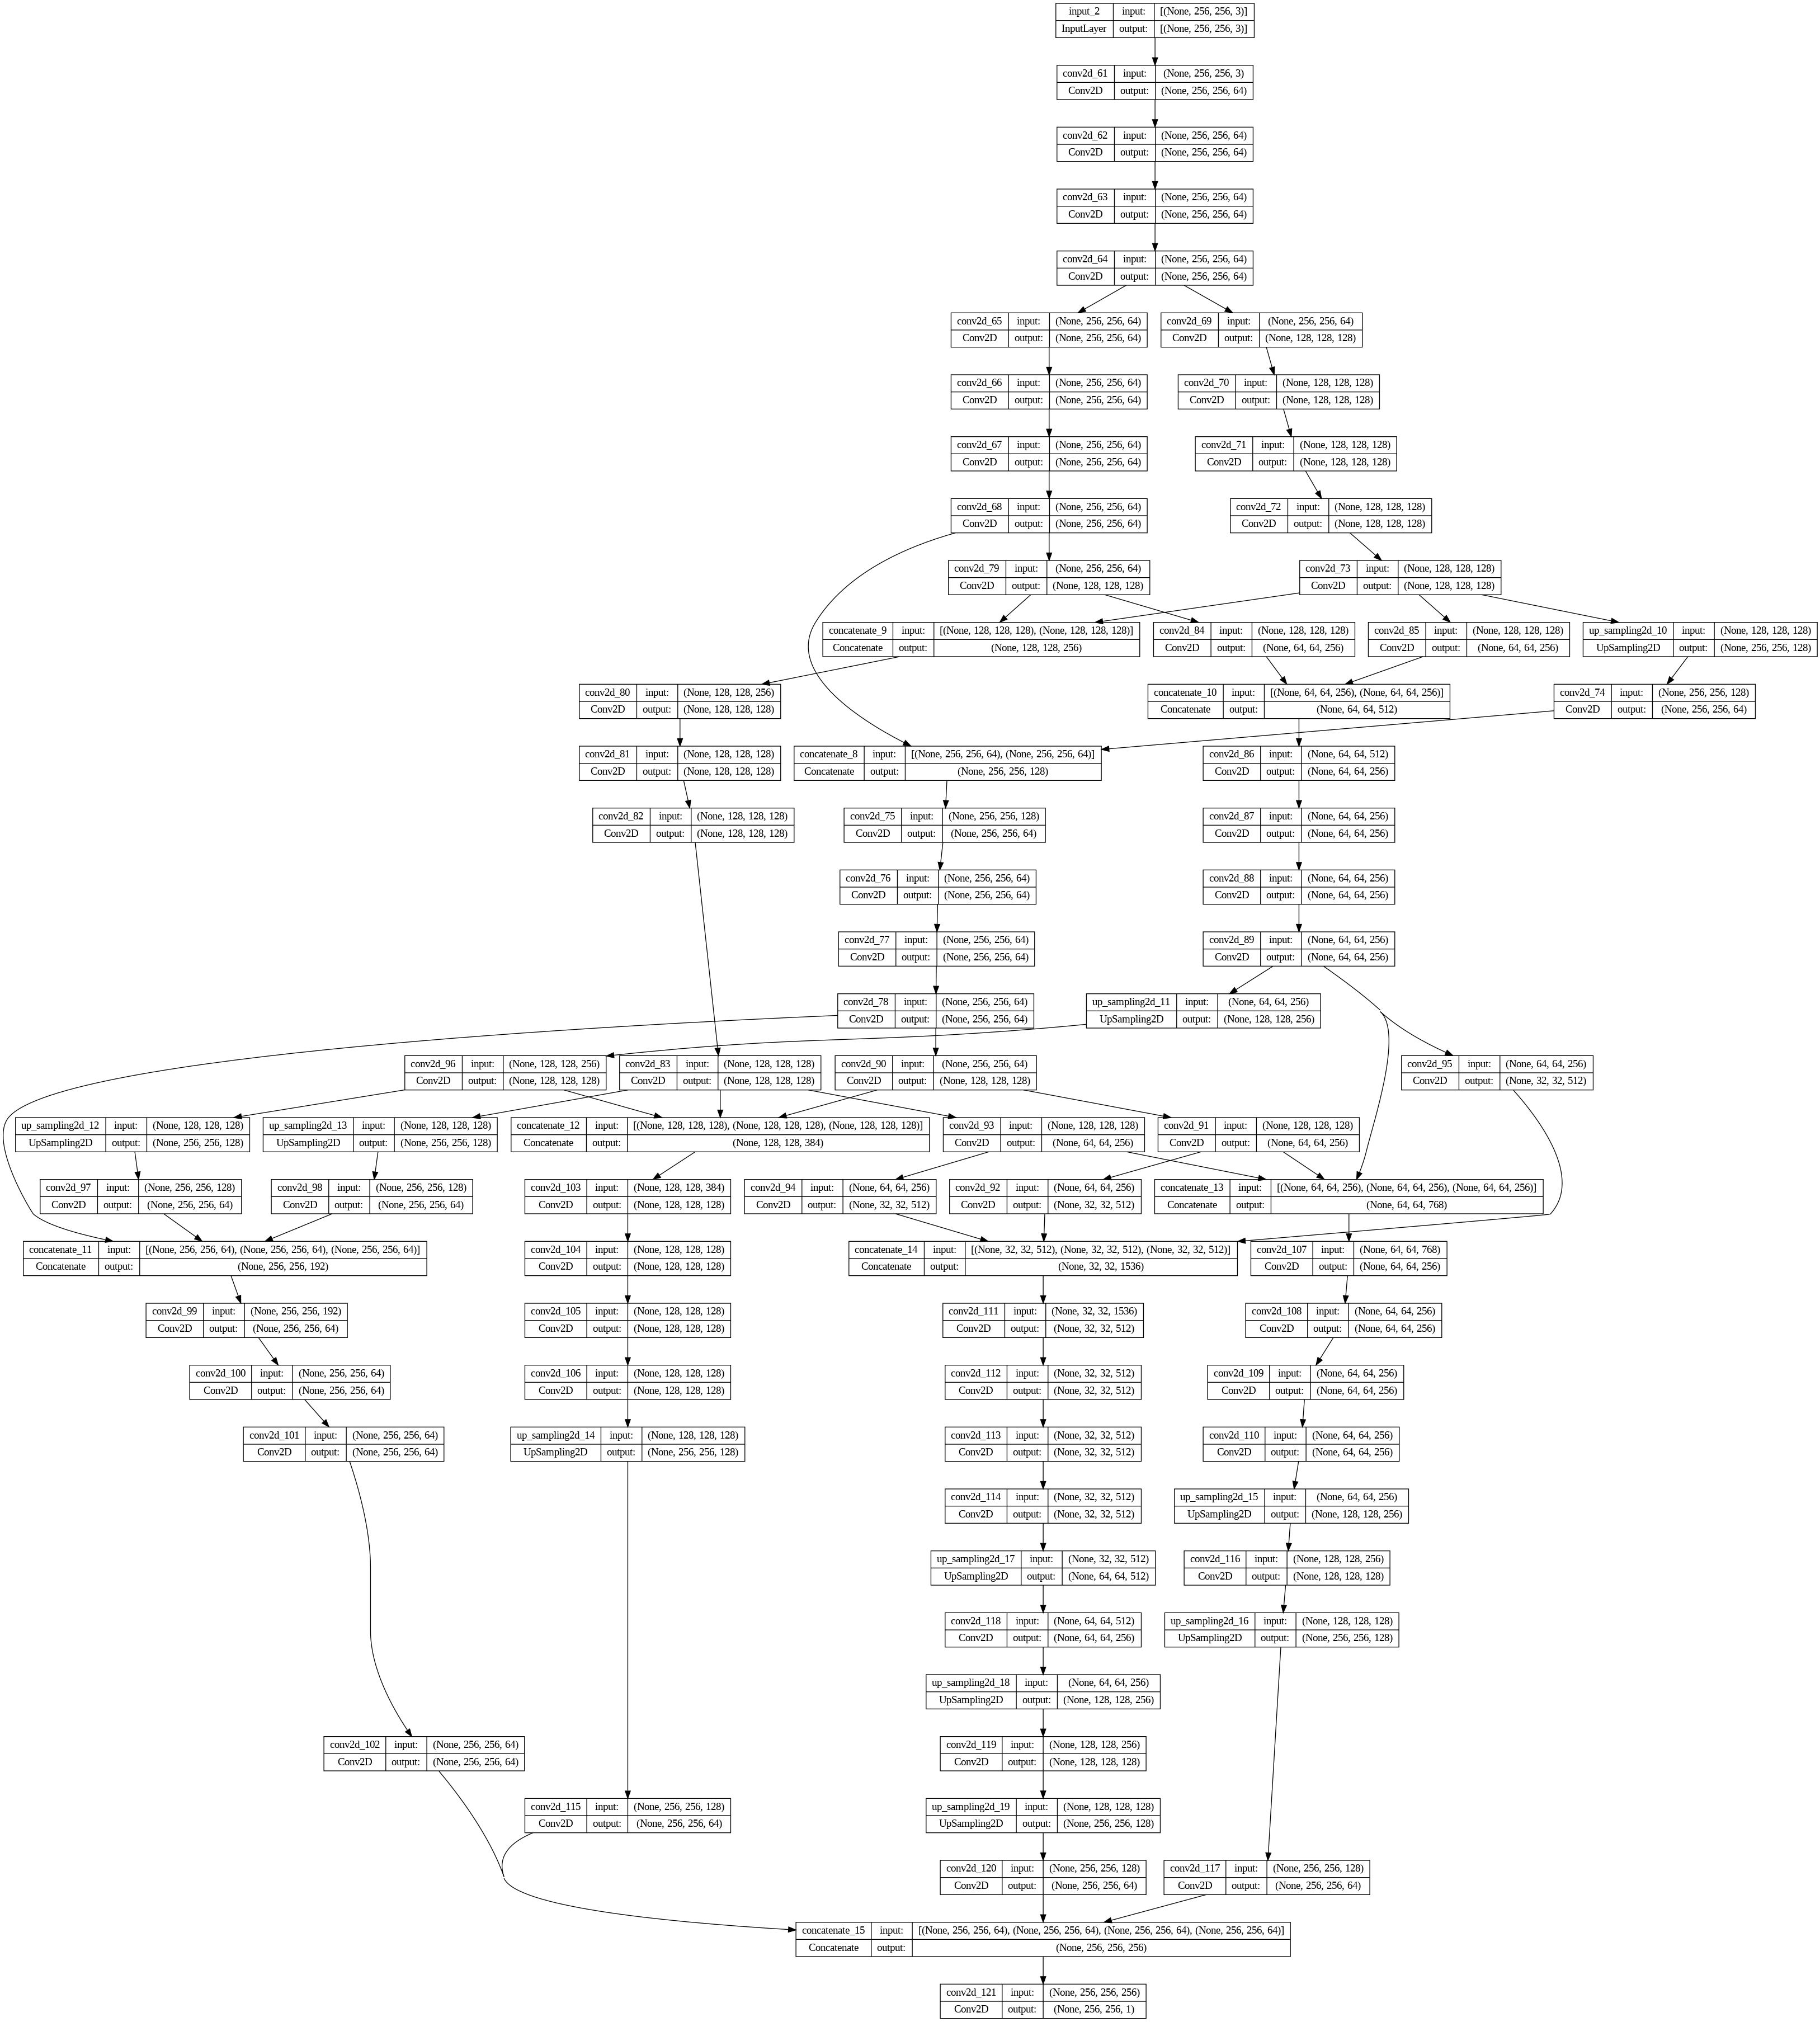

In [ ]:
# from keras.utils import plot_model
# plot_model(model, show_shapes=True)

## Model training

In [ ]:
from keras.callbacks import ReduceLROnPlateau

# Define the learning rate reduction callback
lr_reduction = ReduceLROnPlateau(monitor='loss',  # Metric to monitor (e.g., loss)
                                factor=0.1,      # Factor by which the learning rate will be reduced (new_lr = lr * factor)
                                patience=2,      # Number of epochs with no improvement after which the learning rate will be reduced
                                verbose=1)       # Verbosity mode (1: update messages)
model.fit(x=my_generator,
    steps_per_epoch=50,
    epochs=15,
    callbacks=[lr_reduction],
    verbose=1
)

Epoch 1/15
50/50 [==============================] - 143s 3s/step - loss: 0.1831 - accuracy: 0.9632 - lr: 0.0010
Epoch 2/15
50/50 [==============================] - 76s 2s/step - loss: 0.0764 - accuracy: 0.9813 - lr: 0.0010
Epoch 3/15
50/50 [==============================] - 76s 2s/step - loss: 0.0271 - accuracy: 0.9897 - lr: 0.0010
Epoch 4/15
50/50 [==============================] - 76s 2s/step - loss: 0.0187 - accuracy: 0.9929 - lr: 0.0010
Epoch 5/15
50/50 [==============================] - 76s 2s/step - loss: 0.0166 - accuracy: 0.9933 - lr: 0.0010
Epoch 6/15
50/50 [==============================] - 76s 2s/step - loss: 0.0129 - accuracy: 0.9947 - lr: 0.0010
Epoch 7/15
50/50 [==============================] - 76s 2s/step - loss: 0.0140 - accuracy: 0.9942 - lr: 0.0010
Epoch 8/15
50/50 [==============================] - 76s 2s/step - loss: 0.0098 - accuracy: 0.9960 - lr: 0.0010
Epoch 9/15
50/50 [==============================] - 76s 2s/step - loss: 0.0144 - accuracy: 0.9945 - lr: 0.0010


In [ ]:
model.save("/content/gdrive/MyDrive/MiniProjectDataset/HRNet_OD_model.h5")

## Model Test

In [ ]:
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/MiniProjectDataset/HRNet_OD_model.h5')

In [ ]:
from keras.utils import load_img, img_to_array
import numpy as np

# img = load_img('/content/gdrive/MyDrive/MiniProjectDataset/Refuge/train/combined_images/g0001.jpg', target_size=(256, 256))
# msk = load_img('/content/gdrive/MyDrive/MiniProjectDataset/Refuge/train/combined_gts/g0001.bmp', target_size=(256, 256))
# img = img_to_array(img)

img = load_img('/content/gdrive/MyDrive/MiniProjectDataset/Drishti/images/normal/drishtiGS_008.png', target_size=(256, 256))
msk_OC = load_img('/content/gdrive/MyDrive/MiniProjectDataset/Drishti/OC_gts/normal/drishtiGS_008_CupAvgBoundary_OC_img.png', target_size=(256, 256), color_mode='grayscale')
msk_OD = load_img('/content/gdrive/MyDrive/MiniProjectDataset/Drishti/OD_gts/normal/drishtiGS_008_ODAvgBoundary_OD_img.png', target_size=(256, 256), color_mode='grayscale')

img = img_to_array(img)
msk_OC=img_to_array(msk_OC)
msk_OD=img_to_array(msk_OD)

img = preprocess_image(img)
img = img/255.0
img = np.expand_dims(img, axis=0)
print(img.shape)
pred_mask1 = model.predict(img)

(1, 256, 256, 3)
1/1 [==============================] - 0s 475ms/step


In [ ]:
pred_mask=pred_mask1

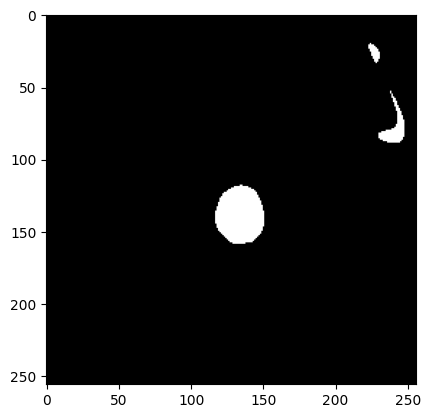

In [ ]:
import matplotlib.pyplot as plt
pred_mask=pred_mask>0.5
pred_mask=pred_mask*255
plt.imshow((pred_mask[0]).astype(np.uint8), cmap='gray')
plt.show()

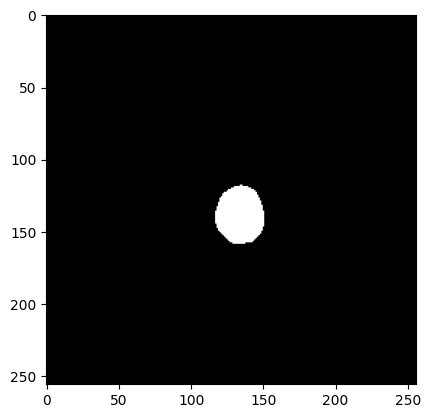

In [ ]:
_, labels, stats, _ = cv2.connectedComponentsWithStats((pred_mask[0]).astype(np.uint8))

largest_region_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

# Create a mask image with only the largest region
mask = np.zeros_like((pred_mask[0]).astype(np.uint8))
mask[labels == largest_region_label] = 255

plt.imshow(mask, cmap='gray')
plt.show()

In [ ]:
# print(pred_mask)
# print(img)

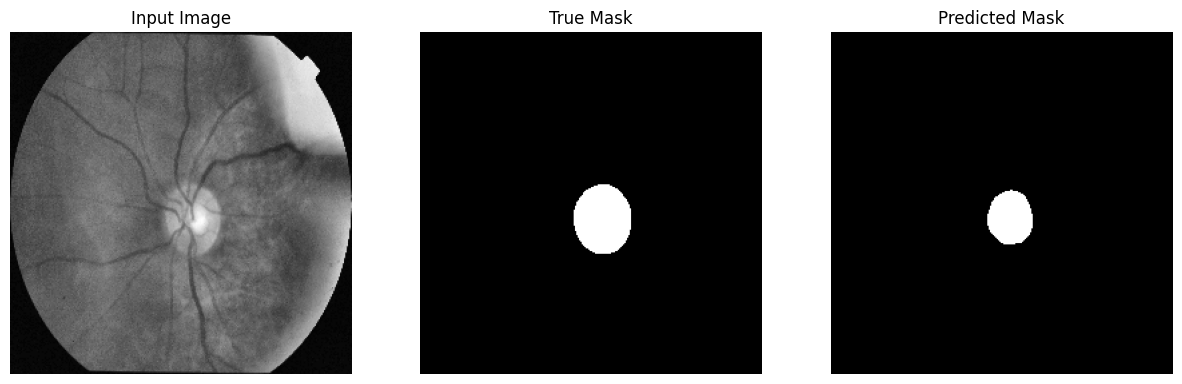

In [ ]:
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask.reshape(256, 256, 1)

# pred_mask[0]=255-pred_mask[0]
# msk=img_to_array(msk)
# msk=msk==0#<255
display([img[0], msk_OD, mask])


# print('dice scrore: ',dice_coefficient(mask, msk_OD))

In [ ]:
# from skimage.transform import resize
# import cv2
# from google.colab.patches import cv2_imshow
# # directory='/content/gdrive/MyDrive/MiniProjectDataset/Refuge/test/images/T0001.jpg'

# images_path='/content/gdrive/MyDrive/MiniProjectDataset/Refuge/test/images'
# image_size=(256,256)
# batch_size= 10
# mask_path='/content/gdrive/MyDrive/MiniProjectDataset/Refuge/test/gts'

# sec_generator= custom_generator(images_path, mask_path, batch_size, image_size)
# data = next(sec_generator)



# def show_predictions(dataset=None, num=1):
#   if dataset:
#     for image, mask in dataset[num]:
#       pred_mask = model.predict(image)
      

# show_predictions(data)